In [2]:
import matplotlib.pyplot as plt
import random
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, execute, Aer, visualization

In [80]:

def createLogicalQubits(numLogicalQubits):
    logicalQubits = []
    for qubit in range(numLogicalQubits):
        physicalQubits = []
        physicalQubits.append(QuantumRegister(3, name='L' + str((qubit + 1)) + 'code0'))
        physicalQubits.append(QuantumRegister(3, name='L' + str((qubit + 1)) + 'code1'))
        physicalQubits.append(QuantumRegister(3, name='L' + str((qubit + 1)) + 'code2'))

        physicalQubits.append(AncillaRegister(2, name='L' + str((qubit + 1)) + 'Z'))
        physicalQubits.append(AncillaRegister(2, name='L' + str((qubit + 1)) + 'X'))

        # For testing code qubits
        physicalQubits.append(ClassicalRegister(3, name='L' + str(qubit +1) + 'code0meas'))
        physicalQubits.append(ClassicalRegister(3, name='L' + str(qubit +1) + 'code1meas'))
        physicalQubits.append(ClassicalRegister(3, name='L' + str(qubit +1) + 'code2meas'))

        # physicalQubits.append(ClassicalRegister(2, name='L' + str(qubit +1) + 'Zmeas'))
        # physicalQubits.append(ClassicalRegister(2, name='L' + str(qubit +1) + 'Xmeas'))

        logicalQubits.append(physicalQubits)
    
    return (QuantumCircuit(*[pqubit for lqubit in logicalQubits for pqubit in lqubit]), logicalQubits)

In [81]:
def applyEncoder(circuit, qubits):
    for qubit in range(len(qubits)):
        circuit.h([qubits[qubit][0][0], qubits[qubit][1][0], qubits[qubit][2][0]])
        for i in range(3):
            circuit.cx(qubits[qubit][i][0], qubits[qubit][i][1])
            circuit.cx(qubits[qubit][i][0], qubits[qubit][i][2])
            circuit.h([qubits[qubit][i][0], qubits[qubit][i][1], qubits[qubit][i][2]])
    circuit.barrier()

In [82]:
def applyXDetection(circuit, qubits):
    for qubit in range(len(qubits)):
        circuit.h([qubits[qubit][4][0], qubits[qubit][4][1]])
        for i in range(2):
            for j in range(9):
                if i == 0:
                    if j % 3 != 2:
                        circuit.cx(qubits[qubit][4][0], qubits[qubit][j // 3][j % 3])
                else:
                    if j % 3 != 0:
                        circuit.cx(qubits[qubit][4][1], qubits[qubit][j // 3][j % 3])
        circuit.h([qubits[qubit][4][0], qubits[qubit][4][1]])
    circuit.barrier()

In [83]:
def applyZDetection(circuit, qubits):
    for qubit in range(len(qubits)):
        for i in range(2):
            for j in range(3):
                circuit.cx(qubits[qubit][i][j], qubits[qubit][3][0])
        for i in range(1, 3):
            for j in range(3):
                circuit.cx(qubits[qubit][i][j], qubits[qubit][3][1])
    circuit.barrier()

In [84]:
def applyMeasurements(circuit, qubits):
    for qubit in range(len(qubits)):
        for i in range(3, 5):
            for j in range(2):
                # For testing both code and ancilla qubits
                # circuit.measure(qubits[qubit][i][j], qubits[qubit][i + 5][j])
                circuit.measure(qubits[qubit][i][j], qubits[qubit][i + 2][j])

In [85]:
def applyCodeMeasurements(circuit, qubits):
    for qubit in range(len(qubits)):
        for i in range(3):
            for j in range(3):
                circuit.measure(qubits[qubit][i][j], qubits[qubit][i + 5][j])

In [86]:
def applyrandomError(circuit, qubits):
    # for qubit in range(len(qubits)):
    for qubit in range(1):
        x = random.randint(0, 2)
        y = random.randint(0, 2)
        circuit.x(qubits[qubit][2][2])
        # circuit.x(qubits[qubit][x][y])
    circuit.barrier()

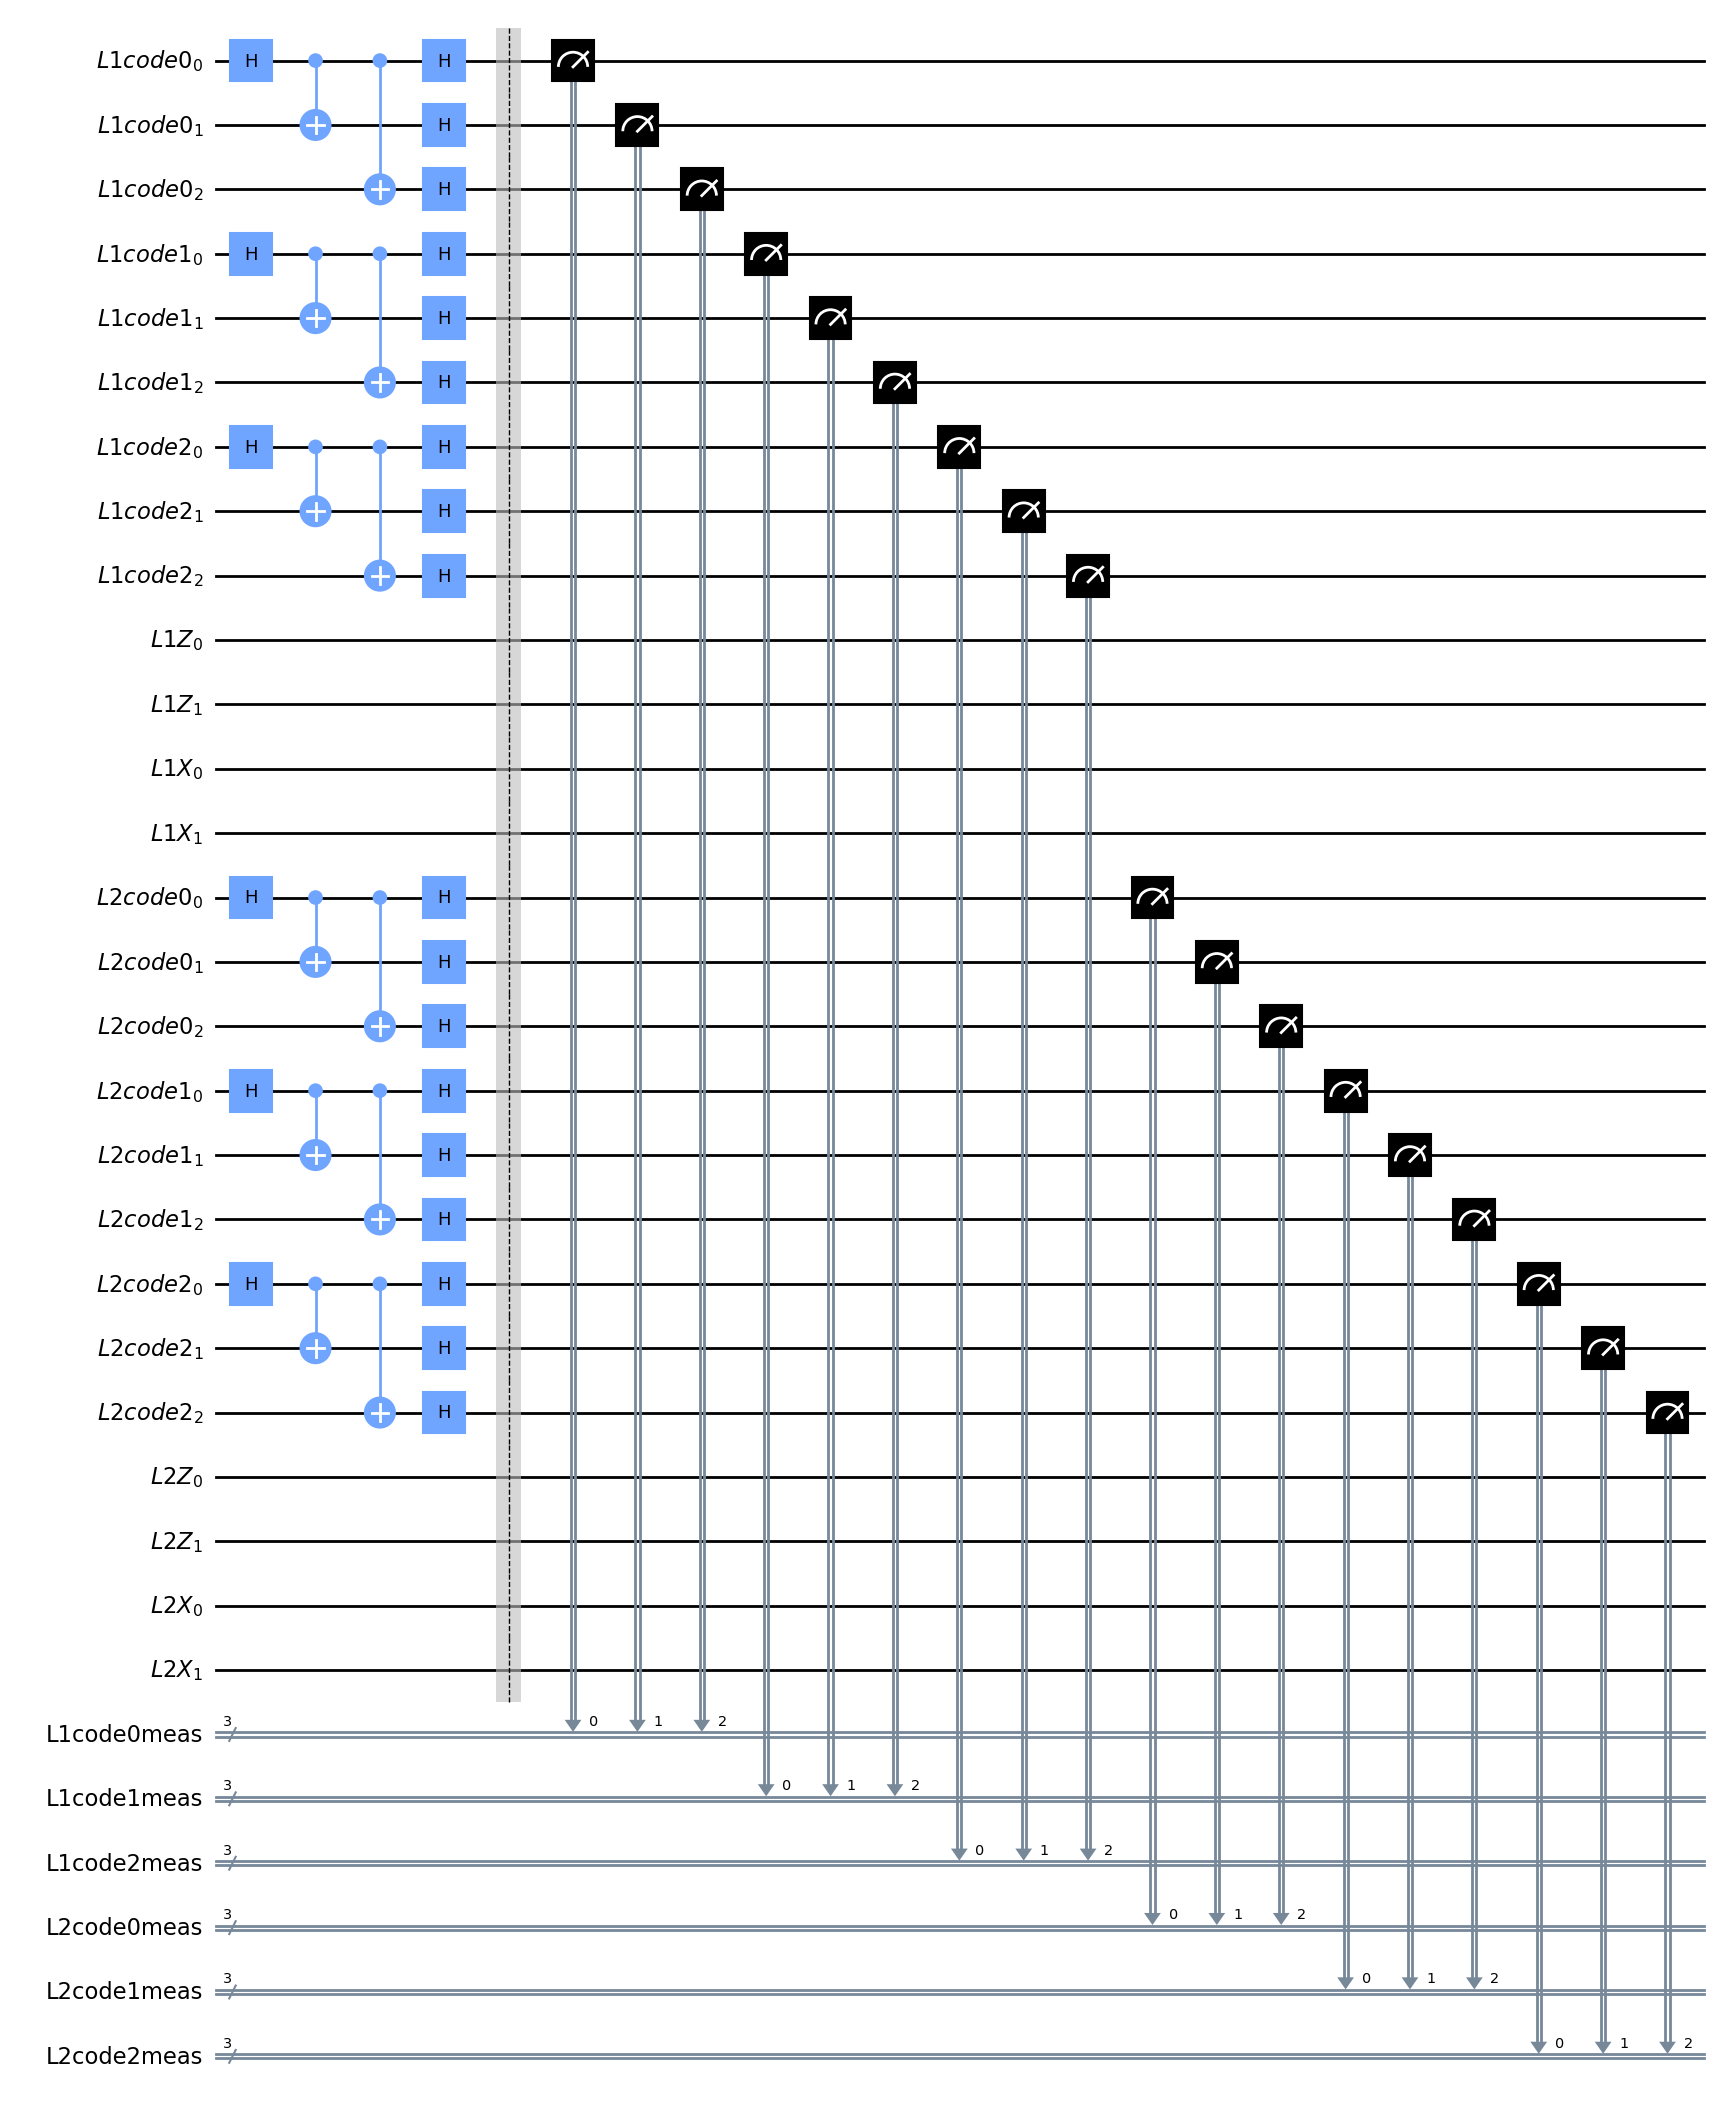

In [87]:
qc, qubits = createLogicalQubits(2)
applyEncoder(qc, qubits)
# applyrandomError(qc, qubits)
# applyXDetection(qc, qubits)
# applyZDetection(qc, qubits)
applyCodeMeasurements(qc, qubits)
# applyMeasurements(qc, qubits)
qc.draw(output='mpl', fold=45)

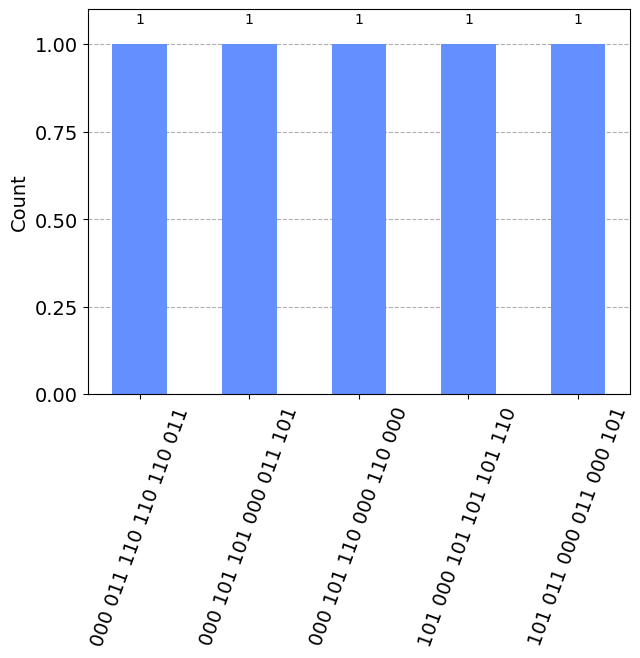

In [88]:
sim = Aer.get_backend('qasm_simulator')
job = execute(qc, sim, shots=5)
result = job.result()
counts = result.get_counts(qc)
visualization.plot_histogram(counts)